In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from IPython.display import display

In [198]:
# Check versions for SMOTE 
'''
import scipy 
print(scipy.__version__)
import sklearn
print(sklearn.__version__)
import imblearn
print(imblearn.__version__)
'''

1.6.2
0.24.1
0.8.0


In [2]:
def load_diabetes_data(path):
    # load in the original data
    diabetes_orig = pd.read_csv(path)

    # take just one person from each household
    diabetes = diabetes_orig.groupby("HHX") \
      .sample(1, random_state=24648765) \
      .reset_index() \
      .copy()
    # add an id column
    diabetes["id"] = np.arange(len(diabetes.index))
    # create the house_family_person_id column by joining together three ID columns
    diabetes["house_family_person_id"] = diabetes.apply(lambda x: "_".join(x[["HHX", "FMX", "FPX"]].astype(int).astype(str)), 
                                                        axis=1)
    # create the diabetes column
    diabetes["diabetes"] = (diabetes["DIBEV1"] == 1).astype(int)
    # create coronary heart disease column
    diabetes["coronary_heart_disease"] = (diabetes["CHDEV"] == 1).astype(int)
    # create hypertension column
    diabetes["hypertension"] = (diabetes["HYPEV"] == 1).astype(int)
    # create heart_condition column
    diabetes["heart_condition"] = (diabetes["HRTEV"] == 1).astype(int)
    # create cancer column
    diabetes["cancer"] = (diabetes["CANEV"] == 1).astype(int)
    # create family_history_diabetes column
    diabetes["family_history_diabetes"] = (diabetes["DIBREL"] == 1).astype(int)
    # rename remaining relevant columns
    diabetes = diabetes.rename(columns={"AGE_P": "age",
                                      "SMKEV": "smoker",
                                      "SEX": "sex",
                                      "AWEIGHTP": "weight",
                                      "BMI": "bmi",
                                      "AHEIGHT": "height"})

    # select just the relevant columns
    diabetes = diabetes[["house_family_person_id",
                        "diabetes",
                        "age",
                        "smoker",
                        "sex",
                        "coronary_heart_disease",
                        "weight",
                        "bmi",
                        "height",
                        "hypertension",
                        "heart_condition",
                        "cancer",
                        "family_history_diabetes"]]
    return(diabetes)

In [53]:
path = '/Users/deberend/Desktop/Cornell Tech/Topics in Data Science and OR/Midterm Project/berend-66-TDSOR_midterm_project_ABE/data/samadult.csv'
df = load_diabetes_data(path)

In [4]:
df

,house_family_person_id,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
0,1_2_1,0,24,2,2,0,125,2019,66,0,0,0,0
1,2_1_1,0,76,2,1,0,190,2727,70,1,0,0,0
2,3_1_2,0,36,2,2,0,225,3862,64,0,0,0,1
3,5_1_1,0,35,1,2,0,240,3995,65,0,0,0,1
4,10_1_5,0,20,2,2,0,103,1883,62,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32494,71559_1_1,0,56,1,1,0,172,2399,71,0,0,1,1
32495,71565_1_1,0,58,1,1,0,225,3141,71,1,0,0,1
32496,71569_1_1,1,71,1,2,1,124,2501,59,1,0,0,1
32497,71576_1_1,0,64,1,1,0,188,2945,67,1,0,0,0


In [8]:
# Create csv file of new df 
#df.to_csv('diabetes.csv', index=False)

In [5]:
# Checking for basic statistics and data information to understand the data better
data_info = df.info()
data_description = df.describe()

# Checking for missing values
missing_values = df.isnull().sum()

# Displaying the outputs
display(data_info, data_description, missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32499 entries, 0 to 32498
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   house_family_person_id   32499 non-null  object
 1   diabetes                 32499 non-null  int64 
 2   age                      32499 non-null  int64 
 3   smoker                   32499 non-null  int64 
 4   sex                      32499 non-null  int64 
 5   coronary_heart_disease   32499 non-null  int64 
 6   weight                   32499 non-null  int64 
 7   bmi                      32499 non-null  int64 
 8   height                   32499 non-null  int64 
 9   hypertension             32499 non-null  int64 
 10  heart_condition          32499 non-null  int64 
 11  cancer                   32499 non-null  int64 
 12  family_history_diabetes  32499 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 3.2+ MB


None

,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
count,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000
mean,0.107142,51.051017,1.608942,1.547494,0.055232,251.113850,3045.910736,68.817748,0.356042,0.089603,0.112865,0.354134
std,0.309298,18.511120,0.609761,0.497747,0.228437,240.280025,1451.552127,8.459210,0.478835,0.285616,0.316433,0.478257
min,0.000000,18.000000,1.000000,1.000000,0.000000,100.000000,1167.000000,59.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,1.000000,1.000000,0.000000,150.000000,2374.000000,64.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,52.000000,2.000000,2.000000,0.000000,176.000000,2724.000000,67.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,66.000000,2.000000,2.000000,0.000000,214.000000,3173.000000,70.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,85.000000,9.000000,2.000000,1.000000,999.000000,9999.000000,99.000000,1.000000,1.000000,1.000000,1.000000


house_family_person_id     0
diabetes                   0
age                        0
smoker                     0
sex                        0
coronary_heart_disease     0
weight                     0
bmi                        0
height                     0
hypertension               0
heart_condition            0
cancer                     0
family_history_diabetes    0
dtype: int64

In [25]:
# Check random rows 
display(df.sample(5))

# Check the anomily smoker counts
display(df['smoker'].value_counts())

,house_family_person_id,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
28365,62404_1_1,0,56,1,1,0,170,2305,72,0,0,0,0
26415,58059_1_1,0,50,2,2,0,103,1883,62,0,0,0,1
31443,69207_1_1,0,24,2,1,0,180,2581,70,0,0,0,0
8947,19719_1_1,0,76,2,2,1,161,3143,60,1,1,0,0
11228,24762_1_1,0,40,2,1,0,259,3940,68,0,0,0,1


2    19071
1    13325
8       59
7       23
9       21
Name: smoker, dtype: int64

## Initial thoughts:
#### Data Structure:
- No missing values in any of the columns.
- The dataset includes 12 numerical columns and 1 object column (house_family_person_id). 

#### Statistical Summary:

**Diabetes**: 10.7% of the individuals have diabetes.

**Age**: The age range is from 18 to 85, with an average of 51 years.

**Smoker**: The majority are non-smokers, but there are some anomalies with values exceeding 2, which might indicate errors.

**Sex**: There seems to be a roughly even split between male (1) and female (2) participants.

**Weight**: Ranges from 100 to 999 pounds, with an average around 251 pounds. 
   - Extreme values (e.g., 999) suggest unreasonable outluers.

**BMI**: Varies from 1167 to 9999 (it appears the BMI has been scaled by a factor of 1000), with a mean of 3045 (or a BMI of 30.45 when scaled back). 
   - Again, unreasonable outlier values here 

**Height**: Ranges from 59 to 99 inches.
   - 99 inch could be possible but very unlikely, so adjust for that
    

Other health indicators:
- 35.6% have hypertension.
- 8.9% have heart conditions.
- 11.3% have cancer.
- 35.4% have a family history of diabetes.

**Potential Anomalies**:
- The smoker column has values above 2, which may represent errors. **Values > 2 will be assumed to be smokers.** 

### Potential subsequent action items:
- make house_family_person_id numeric
- fix scale on BMI (divide by 100)
- fix inconsistent values in the smoker column
- standardize or normalize? (might not be necessary)
- OHE for the categorical variables; smoker and sex, and maybe for BMI and age (by using age bins)
- weight and bmi outliers: Values of 999 for weight and BMI, or extremely high values (e.g., 9999 BMI), suggest outliers or potential errors. You should review these values and decide whether to correct or remove them. This could be done via:
    - Outlier detection (e.g., based on interquartile ranges).
    - Reassessing if these entries represent real-world data (e.g., by calculating BMI from weight and height).
    - other ways?
- **Diabetes Imbalance**: Only about 10.7% of the individuals have diabetes. If you plan to build models for prediction, you may want to address this imbalance using:
    - Oversampling (e.g., SMOTE) or Undersampling.
- **Drop features we don't use** in the prediction part
   
   
    
    
Feature engineering:
- **Age Binning**: Since age has a clear relationship with diabetes, creating age bins (e.g., under 30, 30-50, 50+) to could make the data more interpretable and facilitate categorical analysis. This could help in understanding the risk of diabetes across different life stages.
- **BMI Categories**: Similarly, convert BMI into standard categories (e.g., underweight, normal, overweight, obese) based on medical guidelines. This could help in visual storytelling and improve model performance if you're using machine learning.

### Notes on OHE and SMOTE:
- **Purpose of One-Hot Encoding**: To transform categorical variables into a format that machine learning models can work with, without introducing unintended relationships between categories.
- **Why It’s Important**: It helps algorithms interpret the data correctly by treating each category as a separate, binary feature rather than assuming an arbitrary order or relationship between categories.
- **SMOTE**: Generates new synthetic examples rather than duplicating existing ones, which reduces the risk of overfitting and provides more diverse training data

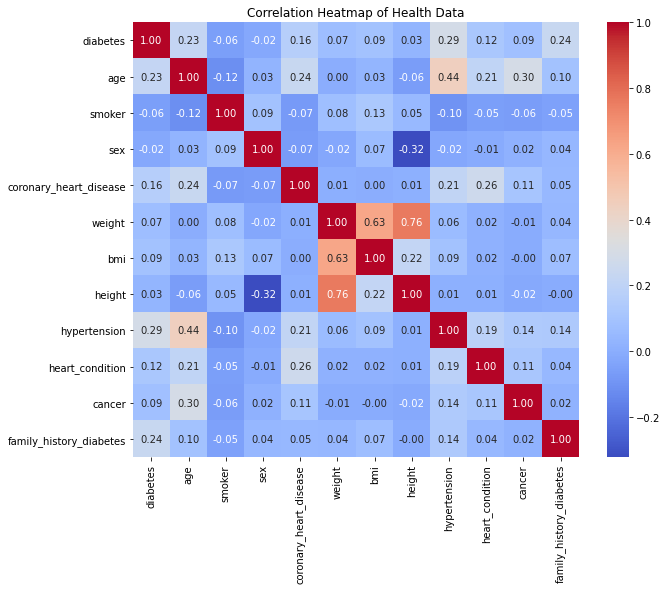

/Users/deberend/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


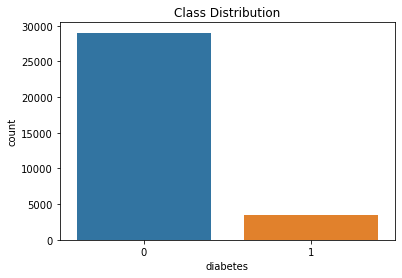

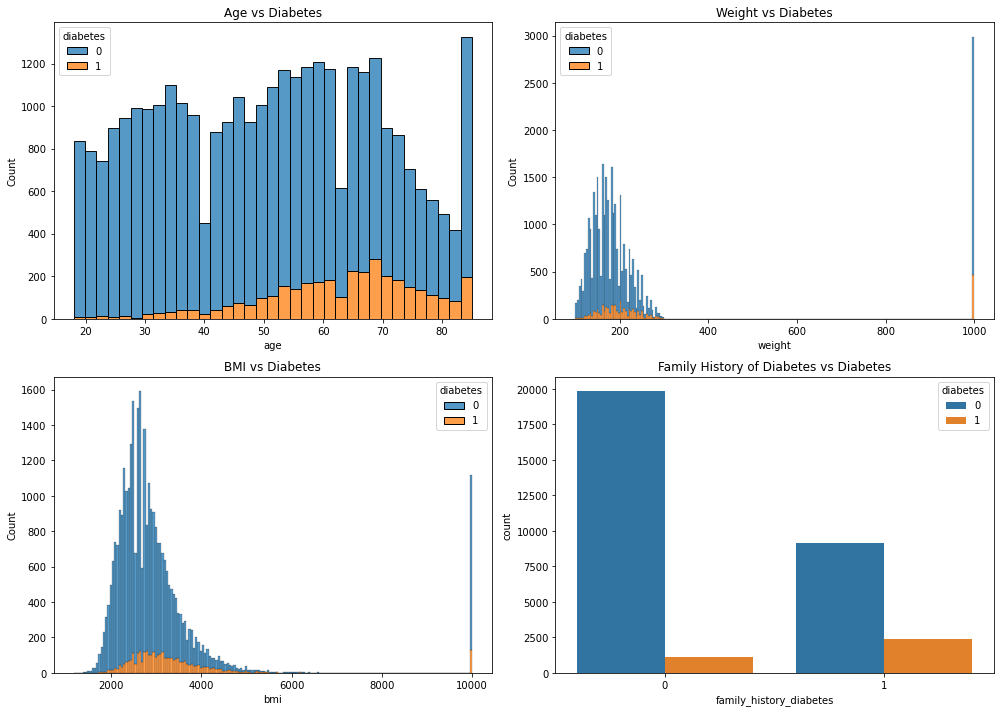

In [88]:
# Plotting the correlation heatmap for all numerical columns
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Health Data")
plt.show()

# Distribution of diabetes
sns.countplot(df['diabetes'])
plt.title('Class Distribution')
plt.show()

# Visualizing the distribution of diabetes across key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age vs Diabetes
sns.histplot(data=df, x='age', hue='diabetes', multiple='stack', ax=axes[0, 0])
axes[0, 0].set_title('Age vs Diabetes')

# Weight vs Diabetes
sns.histplot(data=df, x='weight', hue='diabetes', multiple='stack', ax=axes[0, 1])
axes[0, 1].set_title('Weight vs Diabetes')

# BMI vs Diabetes
sns.histplot(data=df, x='bmi', hue='diabetes', multiple='stack', ax=axes[1, 0])
axes[1, 0].set_title('BMI vs Diabetes')

# Family History of Diabetes vs Diabetes
sns.countplot(data=df, x='family_history_diabetes', hue='diabetes', ax=axes[1, 1])
axes[1, 1].set_title('Family History of Diabetes vs Diabetes')

plt.tight_layout()
plt.show()

In [183]:
def prepareDiabetesData(df, 
                          make_id_numeric=False,
                          rescale_bmi=True, 
                          fix_smoker_values=True, 
                          ohe_categorical=True, 
                          handle_outliers=True,
                          handle_imbalance=False,
                          age_binning=True, 
                          bmi_categorization=True):
    """
    Prepares the diabetes data based on action items.
    
    Parameters:
    df (pandas DataFrame): Input data
    make_id_numeric (bool): Whether to convert 'house_family_person_id' to numeric
    rescale_bmi (bool): Whether to fix BMI scale by dividing by 100
    fix_smoker_values (bool): Whether to fix inconsistent smoker values
    ohe_categorical (bool): Whether to perform one-hot encoding on categorical variables
        note: gender = 1 is Female, gender = 0 is Male 
    handle_outliers (bool): Whether to handle outliers in 'weight' and 'bmi'
    handle_imbalance (bool): Whether to handle diabetes class imbalance using SMOTE
    age_binning (bool): Whether to bin ages
    bmi_categorization (bool): Whether to categorize BMI into standard ranges
    
    Returns:
    pandas DataFrame: Cleaned and processed data
    """
    
    # Create a copy of the dataframe to ensure the original is untouched
    df_cleaned = df.copy()

    # 1. Convert 'house_family_person_id' to numeric
    if make_id_numeric:
        df_cleaned['house_family_person_id'] = pd.factorize(df_cleaned['house_family_person_id'])[0]

    # 2. Fix BMI scale (divide by 100)
    if rescale_bmi:
        df_cleaned['bmi'] = df_cleaned['bmi'] / 100

    # 3. Fix inconsistent smoker values
    if fix_smoker_values:
        df_cleaned['smoker'] = df_cleaned['smoker'].apply(lambda x: 2 if x > 2 else x)

    # 4. Handle outliers for weight and BMI using IQR (before SMOTE)
    if handle_outliers:
        def clip_outliers(col):
            """Clips outliers using the IQR method (1.5*IQR rule)."""
            Q1 = col.quantile(0.25)
            Q3 = col.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return col.clip(lower=lower_bound, upper=upper_bound)
        
        df_cleaned['weight'] = clip_outliers(df_cleaned['weight'])
        df_cleaned['bmi'] = clip_outliers(df_cleaned['bmi'])

    # 5. Handle Diabetes Class Imbalance using SMOTE (before any categorical transformations)
    if handle_imbalance:
        smote = SMOTE(random_state=42)
        X = df_cleaned.drop('diabetes', axis=1)
        y = df_cleaned['diabetes']
        X_res, y_res = smote.fit_resample(X, y)
        df_cleaned = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['diabetes'])], axis=1)

    # 6. Bin Ages into categories (after SMOTE)
    if age_binning:
        df_cleaned['age_bin'] = pd.cut(df_cleaned['age'], bins=[18, 30, 50, 85], labels=['Under 30', '30-50', '50+'])
        if ohe_categorical:
            df_age_ohe = pd.get_dummies(df_cleaned['age_bin'], prefix='age')
            df_cleaned = pd.concat([df_cleaned, df_age_ohe], axis=1)
            df_cleaned.drop('age_bin', axis=1, inplace=True)

    # 7. Categorize BMI into standard medical categories (after SMOTE)
    if bmi_categorization:
        df_cleaned['bmi_category'] = pd.cut(df_cleaned['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')],
                                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        if ohe_categorical:
            df_bmi_ohe = pd.get_dummies(df_cleaned['bmi_category'], prefix='bmi')
            df_cleaned = pd.concat([df_cleaned, df_bmi_ohe], axis=1)
            df_cleaned.drop('bmi_category', axis=1, inplace=True)
    
    # 8. One-Hot Encode categorical variables (smoker, sex, BMI, and age bins)
    if ohe_categorical:
        # Apply OHE to smoker and sex columns
        ohe = OneHotEncoder(drop='first', sparse=False)
        # One-hot encode 'smoker' and 'sex'
        df_ohe = pd.DataFrame(ohe.fit_transform(df_cleaned[['smoker', 'sex']]), 
                              columns=ohe.get_feature_names(['smoker', 'sex']))  # Use get_feature_names for column names

        # Convert one-hot encoded columns to integers (0 or 1)
        df_ohe = df_ohe.astype(int)

        # Concatenate the new one-hot encoded columns back to the original dataframe
        df_cleaned = pd.concat([df_cleaned, df_ohe], axis=1)

        # Drop the original 'smoker' and 'sex' columns
        df_cleaned.drop(['smoker', 'sex'], axis=1, inplace=True)
        
        # Rename for clarity
        df_cleaned.rename(columns={'smoker_2': 'smoker', 'sex_2': 'gender'}, inplace=True)
    
    return df_cleaned  # Return the cleaned dataframe

In [204]:
df_cleaned = prepareDiabetesData(df, 
                                 make_id_numeric=True,
                          rescale_bmi=True, 
                          fix_smoker_values=True, 
                          ohe_categorical=True, 
                          handle_outliers=True,
                          handle_imbalance=True,
                          age_binning=True, 
                          bmi_categorization=True)

In [205]:
display(df_cleaned)
display(df_cleaned.shape)

,house_family_person_id,age,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes,diabetes,age_Under 30,age_30-50,age_50+,bmi_Underweight,bmi_Normal,bmi_Overweight,bmi_Obese,smoker,gender
0,0,24,0,125,20.190000,66,0,0,0,0,0,1,0,0,0,1,0,0,1,1
1,1,76,0,190,27.270000,70,1,0,0,0,0,0,0,1,0,0,1,0,1,0
2,2,36,0,225,38.620000,64,0,0,0,1,0,0,1,0,0,0,0,1,1,1
3,3,35,0,240,39.950000,65,0,0,0,1,0,0,1,0,0,0,0,1,0,1
4,4,20,0,103,18.830000,62,0,0,0,1,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58029,6215,70,0,195,34.727673,62,1,0,0,1,1,0,0,1,0,0,0,1,1,1
58030,6242,69,0,202,29.393710,69,1,0,0,1,1,0,0,1,0,0,1,0,0,0
58031,28201,61,1,241,37.830092,67,1,0,0,0,1,0,0,1,0,0,0,1,1,0
58032,18998,84,0,143,25.787966,62,1,0,0,0,1,0,0,1,0,0,1,0,1,1


(58034, 20)

In [206]:
display(df_cleaned.columns)

Index(['house_family_person_id', 'age', 'coronary_heart_disease', 'weight',
       'bmi', 'height', 'hypertension', 'heart_condition', 'cancer',
       'family_history_diabetes', 'diabetes', 'age_Under 30', 'age_30-50',
       'age_50+', 'bmi_Underweight', 'bmi_Normal', 'bmi_Overweight',
       'bmi_Obese', 'smoker', 'gender'],
      dtype='object')

## EDA on cleaned data

In [207]:
# Checking for basic statistics and data information to understand the data better
data_cleaned_info = df_cleaned.info()
data_cleaned_description = df_cleaned.describe()
display(data_cleaned_info, data_cleaned_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58034 entries, 0 to 58033
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   house_family_person_id   58034 non-null  int64  
 1   age                      58034 non-null  int64  
 2   coronary_heart_disease   58034 non-null  int64  
 3   weight                   58034 non-null  int64  
 4   bmi                      58034 non-null  float64
 5   height                   58034 non-null  int64  
 6   hypertension             58034 non-null  int64  
 7   heart_condition          58034 non-null  int64  
 8   cancer                   58034 non-null  int64  
 9   family_history_diabetes  58034 non-null  int64  
 10  diabetes                 58034 non-null  int64  
 11  age_Under 30             58034 non-null  uint8  
 12  age_30-50                58034 non-null  uint8  
 13  age_50+                  58034 non-null  uint8  
 14  bmi_Underweight       

None

,house_family_person_id,age,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes,diabetes,age_Under 30,age_30-50,age_50+,bmi_Underweight,bmi_Normal,bmi_Overweight,bmi_Obese,smoker,gender
count,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000,58034.000000
mean,16310.279939,56.232691,0.044715,196.324155,29.898031,68.754006,0.453613,0.066840,0.080108,0.400679,0.500000,0.093755,0.223679,0.675759,0.009942,0.219010,0.332098,0.438950,0.438364,0.426957
std,9369.729061,16.700105,0.206680,52.830941,6.393176,8.392186,0.497848,0.249747,0.271463,0.490040,0.500004,0.291491,0.416713,0.468095,0.099216,0.413579,0.470970,0.496263,0.496191,0.494640
min,0.000000,18.000000,0.000000,100.000000,11.755000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8215.000000,45.000000,0.000000,159.000000,25.120000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16421.500000,59.000000,0.000000,186.000000,28.930000,67.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24470.000000,69.000000,0.000000,225.000000,33.694767,70.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,32498.000000,85.000000,1.000000,310.000000,43.715000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


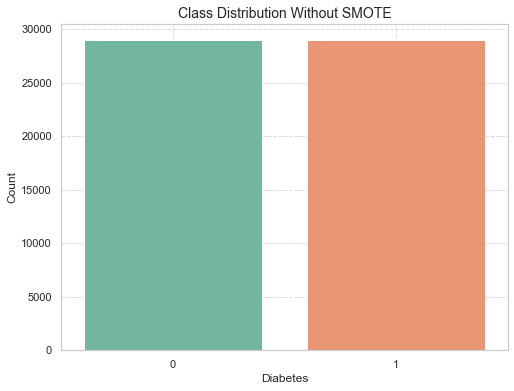

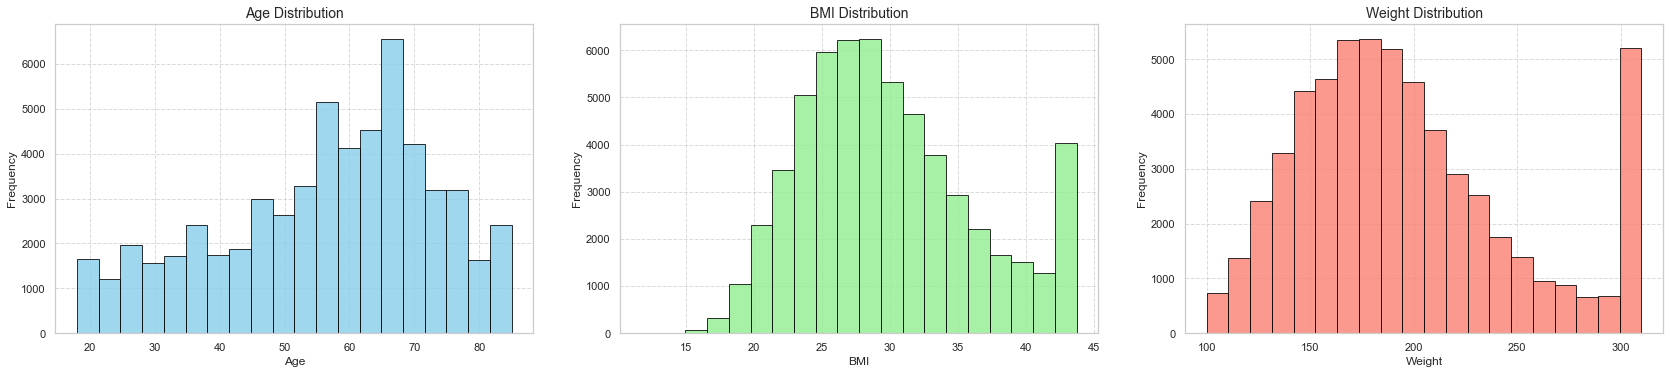

In [208]:
# Set the style
sns.set(style="whitegrid")

# Set to false if SMOTE is not applied
handle_imbalance = False
if handle_imbalance:
    # Create the countplot with custom colors and style
    plt.figure(figsize=(8, 6))
    sns.countplot(x='diabetes', data=df_cleaned, palette='Set2', edgecolor=None)

    # Add a title and labels
    plt.title('Class Distribution After SMOTE', fontsize=14)
    plt.xlabel('Diabetes', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot with adjusted layout
    plt.tight_layout
else: 
    # Create the countplot with custom colors and style
    plt.figure(figsize=(8, 6))
    sns.countplot(x='diabetes', data=df_cleaned, palette='Set2', edgecolor=None)

    # Add a title and labels
    plt.title('Class Distribution Without SMOTE', fontsize=14)
    plt.xlabel('Diabetes', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot with adjusted layout
    plt.tight_layout


#### Next Plot ####

# Step 1: Create a figure with 3 subplots for the histograms and the countplot
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 4 columns for larger plots

# Step 2: Plot histograms for 'age', 'bmi', and 'weight'
# Age
df_cleaned['age'].plot(kind='hist', bins=20, ax=axes[0], alpha=0.8, color='skyblue', edgecolor='black')
axes[0].set_title('Age Distribution', fontsize=14)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# BMI
df_cleaned['bmi'].plot(kind='hist', bins=20, ax=axes[1], alpha=0.8, color='lightgreen', edgecolor='black')
axes[1].set_title('BMI Distribution', fontsize=14)
axes[1].set_xlabel('BMI', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Weight
df_cleaned['weight'].plot(kind='hist', bins=20, ax=axes[2], alpha=0.8, color='salmon', edgecolor='black')
axes[2].set_title('Weight Distribution', fontsize=14)
axes[2].set_xlabel('Weight', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)


# Step 4: Add gridlines for better readability
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.7)

# Step 5: Show the plots with better spacing
plt.tight_layout(pad=3.0)  # Adjust layout for better spacing
plt.show()



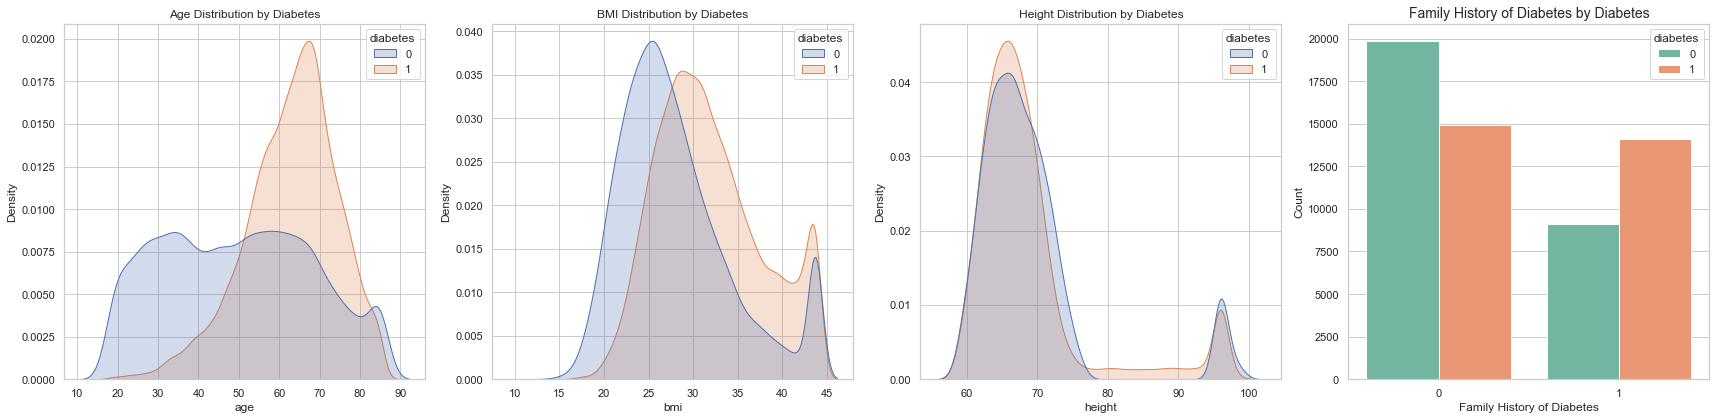

In [209]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  

# Plot distribution of 'age' with respect to 'diabetes'
sns.kdeplot(data=df_cleaned, x='age', hue='diabetes', fill=True, ax=axes[0])
axes[0].set_title('Age Distribution by Diabetes')

# Plot distribution of 'bmi' with respect to 'diabetes'
sns.kdeplot(data=df_cleaned, x='bmi', hue='diabetes', fill=True, ax=axes[1])
axes[1].set_title('BMI Distribution by Diabetes')

# Plot distribution of 'height' with respect to 'diabetes'
sns.kdeplot(data=df_cleaned, x='height', hue='diabetes', fill=True, ax=axes[2])
axes[2].set_title('Height Distribution by Diabetes')

sns.countplot(data=df_cleaned, x='family_history_diabetes', hue='diabetes', palette='Set2', ax=axes[3])
axes[3].set_title('Family History of Diabetes by Diabetes', fontsize=14)
axes[3].set_xlabel('Family History of Diabetes', fontsize=12)
axes[3].set_ylabel('Count', fontsize=12)

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### ^^^outliers with weight distrib, BMI distrib and Height distrib might need to be handled more? 


### Also, remove all other features that we will not be using in the methods steps.